In [ ]:
#import modules
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from scipy import linalg

import matplotlib.style #some style nonsense
import matplotlib as mpl


#train neural network on MNIST dataset, ~ 1 min runtime

#Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images,test_labels) = mnist.load_data()

# Normalise and reshape data
# Normalise pixel values to be between 0 and 1
train_images_normal, test_images_normal = train_images / 255.0, test_images / 255.0

#build neural network that trains on MNIST dataset
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

#compile the model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#train the model
history = model.fit(train_images_normal, train_labels, epochs=15, batch_size=64, validation_split=0.2)


Epoch 1/15
750/750 [==============================] - 3s 4ms/step - loss: 0.3235 - accuracy: 0.9108 - val_loss: 0.1757 - val_accuracy: 0.9498
Epoch 2/15
750/750 [==============================] - 3s 4ms/step - loss: 0.1477 - accuracy: 0.9577 - val_loss: 0.1342 - val_accuracy: 0.9611
Epoch 3/15
750/750 [==============================] - 3s 3ms/step - loss: 0.1034 - accuracy: 0.9703 - val_loss: 0.1119 - val_accuracy: 0.9674
Epoch 4/15
750/750 [==============================] - 4s 5ms/step - loss: 0.0792 - accuracy: 0.9770 - val_loss: 0.0976 - val_accuracy: 0.9717
Epoch 5/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0632 - accuracy: 0.9813 - val_loss: 0.0937 - val_accuracy: 0.9719
Epoch 6/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0494 - accuracy: 0.9859 - val_loss: 0.0901 - val_accuracy: 0.9726
Epoch 7/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0415 - accuracy: 0.9880 - val_loss: 0.0884 - val_accuracy: 0.9729
Epoch 

In [ ]:
def apply_pca(data):
    # Reshape data
    X = np.reshape(data, (data.shape[0], -1))

    # Compute mean
    mu = np.mean(X, axis=0)
    x = X - mu

    # Compute covariance matrix
    rho = np.cov(x, rowvar=False)

    # Get the eigenvalues and eigenvectors
    vals, vecs = linalg.eigh(rho)

    # Sort eigenvectors and eigenvalues in descending order of importance for PCA
    vecs = np.flip(vecs, axis=1)
    vals = np.flip(vals)

    return vecs, vals

# Apply PCA on training images
train_vecs, train_vals = apply_pca(train_images_normal)

# Apply PCA on testing images
test_vecs, test_vals = apply_pca(test_images_normal)

# Check shapes
print("Train eigenvectors shape:", train_vecs.shape)
print("Train eigenvalues shape:", train_vals.shape)
print("Test eigenvectors shape:", test_vecs.shape)
print("Test eigenvalues shape:", test_vals.shape)

Train eigenvectors shape: (784, 784)
Train eigenvalues shape: (784,)
Test eigenvectors shape: (784, 784)
Test eigenvalues shape: (784,)


In [ ]:
def reconstruct_images_with_pca(test_images, eigenvectors, N):
    # Reshape test images to 2D
    test_reshaped = np.reshape(test_images, (test_images.shape[0], -1))
    # Calculate the mean
    mu_test = np.mean(test_reshaped, axis=0)
    # Center the test images
    x_test = test_reshaped - mu_test

    # Project the test images onto the PCA components
    P_test = np.dot(x_test, eigenvectors)

    # Reconstruct images using the N-best PCA components
    output_image = np.dot(P_test[:,0:N], eigenvectors.T[0:N, :]) + mu_test

    return output_image


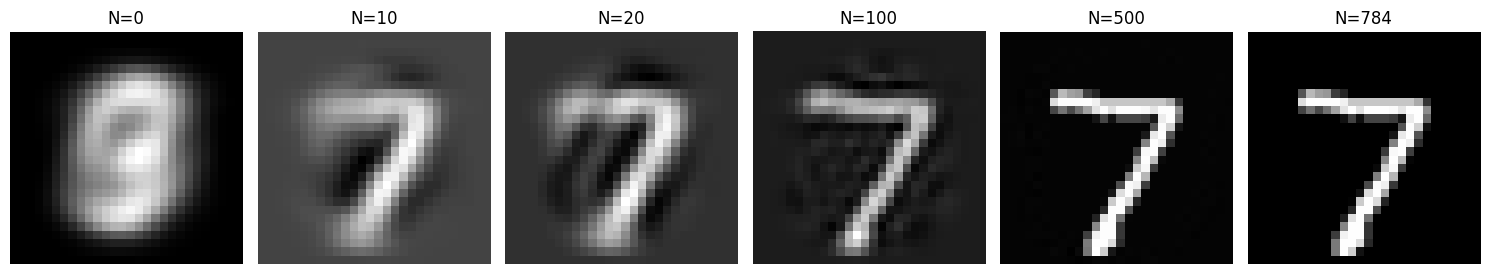

In [ ]:

# Specify the N value you want to use for reconstruction
N_values = [0, 10, 20, 100, 500, 784]

# Create subplots
fig, axes = plt.subplots(1, len(N_values), figsize=(15, 6))

# Plot original and reconstructed images
for i, N in enumerate(N_values):
    # Original images
    mod_images = reconstruct_images_with_pca(test_images, test_vecs, N)
    final_image = mod_images[0]
    axes[i].imshow(final_image.reshape(28, 28), cmap='gray')  # Reshape if necessary
    axes[i].axis('off')
    axes[i].set_title(f"N={N}")

# Display the plot
plt.tight_layout()
plt.show()


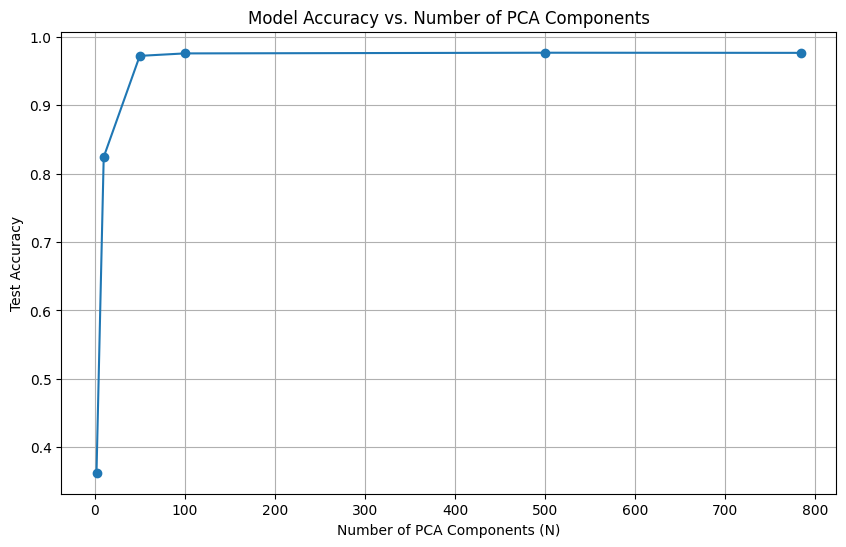

In [ ]:

def evaluate_model_on_pca(test_images, eigenvectors, N_values, model, test_labels):

    accuracies = []
    for N in N_values:
        # Reconstruct test images using the given N value
        reconstructed_images = reconstruct_images_with_pca(test_images, eigenvectors, N)

        # Reshape reconstructed images for CNN input shape
        reconstructed_images_cnn = np.reshape(reconstructed_images, (-1, 28, 28, 1))

        # Evaluate the model on the reconstructed test set
        test_loss, test_acc = model.evaluate(reconstructed_images_cnn, test_labels, verbose=0)

        # Store the test accuracy
        accuracies.append(test_acc)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(N_values, accuracies, marker='o')
    plt.xlabel('Number of PCA Components (N)')
    plt.ylabel('Test Accuracy')
    plt.title('Model Accuracy vs. Number of PCA Components')
    plt.grid(True)
    plt.show()

    return accuracies


# Example usage
# test_accuracies = evaluate_model_on_pca(test_images, vecs, N_values, model, test_labels)

N_values_1 = np.arange(0, 100, 5)

# Define Nvalues with step size 50 between 100 and 785
N_values_2 = np.arange(100, 785, 50)

# Concatenate the two arrays to get the final N values array
N_values_plot = np.concatenate([N_values_1, N_values_2])

# Call the function with the necessary parameters
test_accuracies = evaluate_model_on_pca(test_images, test_vecs, N_values_plot, model, test_labels)


In [ ]:
#compile the model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Specify the N value you want to use for reconstruction
N = 100

# Generate the reconstructed images using the specified N value
reconstructed_N_images_train = reconstruct_images_with_pca(train_images_normal, train_vecs, N)

# Reshape reconstructed images for CNN input shape
reconstructed_images_cnn_train = np.reshape(reconstructed_N_images_train, (-1, 28, 28, 1))


#train the model
history = model.fit(reconstructed_images_cnn_train, train_labels, epochs=15, batch_size=64, validation_split=0.2)


Epoch 1/15
750/750 [==============================] - 6s 7ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.0956 - val_accuracy: 0.9742
Epoch 2/15
750/750 [==============================] - 3s 3ms/step - loss: 0.0246 - accuracy: 0.9916 - val_loss: 0.0874 - val_accuracy: 0.9767
Epoch 3/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0908 - val_accuracy: 0.9753
Epoch 4/15
750/750 [==============================] - 3s 5ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.1012 - val_accuracy: 0.9739
Epoch 5/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0890 - val_accuracy: 0.9773
Epoch 6/15
750/750 [==============================] - 3s 3ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.0925 - val_accuracy: 0.9757
Epoch 7/15
750/750 [==============================] - 3s 3ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0936 - val_accuracy: 0.9762
Epoch 

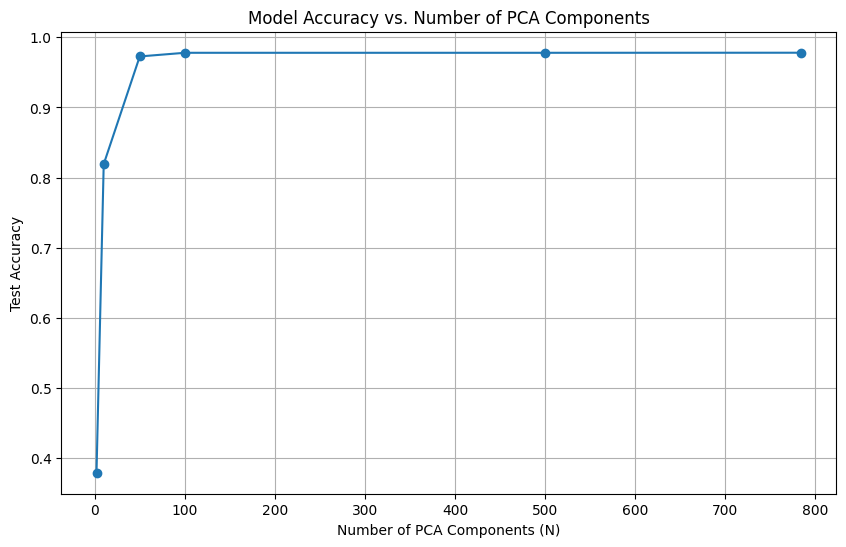

In [ ]:
N_values_1 = np.arange(0, 100, 5)

# Define Nvalues with step size 50 between 100 and 785
N_values_2 = np.arange(100, 785, 50)

# Concatenate the two arrays to get the final N values array
N_values_plot = np.concatenate([N_values_1, N_values_2])

# Call the function with the necessary parameters
test_accuracies = evaluate_model_on_pca(test_images, test_vecs, N_values_plot, model, test_labels)

In [ ]:
#compile the model
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Specify the N value you want to use for reconstruction
N = 20

# Generate the reconstructed images using the specified N value
reconstructed_N_images_train = reconstruct_images_with_pca(train_images_normal, train_vecs, N)

# Reshape reconstructed images for CNN input shape
reconstructed_images_cnn_train = np.reshape(reconstructed_N_images_train, (-1, 28, 28, 1))




#train the model
history = model.fit(reconstructed_images_cnn_train, train_labels, epochs=15, batch_size=64, validation_split=0.2)


Epoch 1/15
750/750 [==============================] - 4s 4ms/step - loss: 0.1563 - accuracy: 0.9561 - val_loss: 0.1400 - val_accuracy: 0.9601
Epoch 2/15
750/750 [==============================] - 3s 4ms/step - loss: 0.1134 - accuracy: 0.9644 - val_loss: 0.1374 - val_accuracy: 0.9628
Epoch 3/15
750/750 [==============================] - 3s 4ms/step - loss: 0.1002 - accuracy: 0.9676 - val_loss: 0.1241 - val_accuracy: 0.9658
Epoch 4/15
750/750 [==============================] - 5s 6ms/step - loss: 0.0903 - accuracy: 0.9706 - val_loss: 0.1288 - val_accuracy: 0.9646
Epoch 5/15
750/750 [==============================] - 3s 3ms/step - loss: 0.0863 - accuracy: 0.9720 - val_loss: 0.1180 - val_accuracy: 0.9669
Epoch 6/15
750/750 [==============================] - 2s 3ms/step - loss: 0.0815 - accuracy: 0.9735 - val_loss: 0.1203 - val_accuracy: 0.9657
Epoch 7/15
750/750 [==============================] - 3s 3ms/step - loss: 0.0773 - accuracy: 0.9754 - val_loss: 0.1271 - val_accuracy: 0.9652
Epoch 

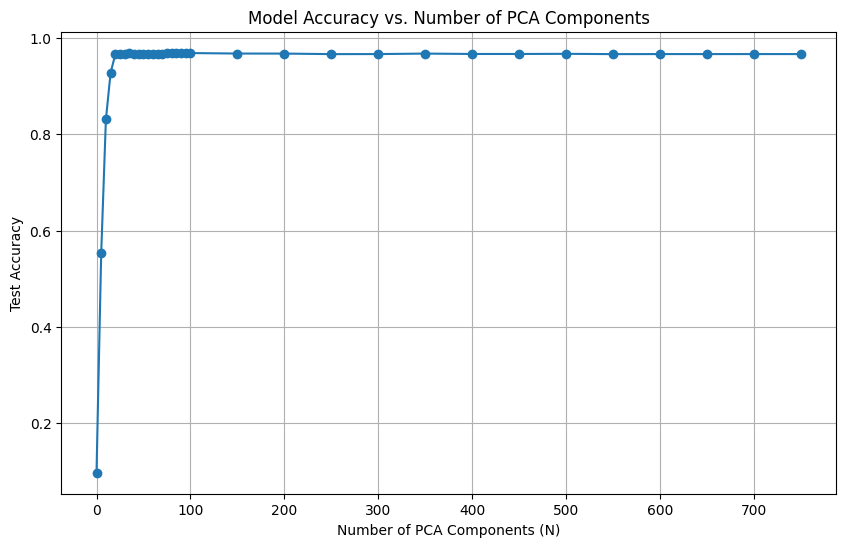

In [ ]:
N_values_1 = np.arange(0, 100, 5)

# Define Nvalues with step size 50 between 100 and 785
N_values_2 = np.arange(100, 785, 50)

# Concatenate the two arrays to get the final N values array
N_values_plot = np.concatenate([N_values_1, N_values_2])

# Call the function with the necessary parameters
test_accuracies = evaluate_model_on_pca(test_images, test_vecs, N_values_plot, model, test_labels)


Conclusion:
In our study, we explored how the number of Principal Component Analysis (PCA) components affects the performance of neural network classifiers on the MNIST dataset. We analyzed three scenarios: N-best PCA evaluated on the original trained model, 100 PCA trained model, and 20 PCA trained model.

1) Effect of PCA Components on Performance: We observed a rapid increase in accuracy with increasing PCA components, followed by a plateau or slight decline beyond a certain threshold. This suggests an optimal number of PCA components that maximizes classifier performance.

2) Optimal Network Configuration: The optimal network configuration depends on the number of PCA components used. With fewer components, simpler architectures suffice, while more complex architectures are required as the number of components increases to fully leverage additional information without overfitting.

3) Interpretation of Plot Trends: Plots illustrating the relationship between PCA components and classifier accuracy revealed rapid initial improvement followed by stabilization or slight decline. This underscores the importance of selecting an appropriate number of PCA components.

Implications: Different PCA configurations yielded varied performance, with 100 PCA components providing comparable accuracy to the original model. However, the 20 PCA model exhibited a pronounced peak in accuracy, suggesting it captures essential data features. The natural peak observed at 20 PCA was less pronounced when training on 100 PCA, indicating a trade-off between dimensionality reduction and classification performance.

Final Accuracy:
- Original Model: Validation Accuracy: 97.50%
- 100 PCA Model: Validation Accuracy: 97.72%
- 20 PCA Model: Validation Accuracy: 96.78%

In summary, our study highlights the significance of PCA components in influencing classifier performance and offers insights into optimizing model architecture and training strategies for real-world applications.
